In [3]:
install.packages("h2o", dependencies = TRUE)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘httpuv’, ‘xtable’, ‘sourcetools’, ‘fastmap’, ‘miniUI’, ‘webshot’, ‘misc3d’, ‘bitops’, ‘bit’, ‘shiny’, ‘manipulateWidget’, ‘plot3D’, ‘RCurl’, ‘mlbench’, ‘slam’, ‘bit64’, ‘data.table’, ‘rgl’, ‘plot3Drgl’




In [0]:
# Cargando datos
load("/Datos_Test2019.Rdata")
load("/Datos_Train2015.Rdata")

In [0]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [0]:
# Cargando  e iniciando h2o
library(h2o)
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Train y Test h2o
df_train <- df_train_2015 %>% 
  select(-Square_ID)

# Datos h2o
datos_h2o <- as.h2o(x = df_train, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.7, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_H2O")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_H2O")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_H2O")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpibhVbJ/file7d745ef74a/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpibhVbJ/file7d76999b6e/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 743 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_root_pcl675 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10.00 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         

# Modelo XGBoost

In [0]:
xgb <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb_model_1"
                  ,stopping_rounds = 3
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,score_tree_interval = 1
                  ,learn_rate=0.05
                  ,ntrees=500
                  ,subsample = 0.75
                  ,colsample_bytree = 0.75
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 0.0
                  ,max_runtime_secs = 3600
                  ,nfolds = 10
                  ,seed = 123
                  )

  |======================================================================| 100%


In [0]:
# Resultados del modelo
xgb

Model Details:

H2ORegressionModel: xgboost
Model ID:  xgb_model_1 
Model Summary: 
  number_of_trees
1             102


H2ORegressionMetrics: xgboost
** Reported on training data. **

MSE:  0.01007705
RMSE:  0.1003845
MAE:  0.04591141
RMSLE:  0.07370958
Mean Residual Deviance :  0.284296


H2ORegressionMetrics: xgboost
** Reported on validation data. **

MSE:  0.01223584
RMSE:  0.1106157
MAE:  0.05002383
RMSLE:  0.08085365
Mean Residual Deviance :  0.3124366


H2ORegressionMetrics: xgboost
** Reported on cross-validation data. **
** 10-fold cross-validation on training data (Metrics computed for combined holdout predictions) **

MSE:  0.01251186
RMSE:  0.1118564
MAE:  0.0513965
RMSLE:  0.08202745
Mean Residual Deviance :  0.2984159


Cross-Validation Metrics Summary: 
                              mean           sd  cv_1_valid  cv_2_valid
mae                    0.051419634  0.006227791 0.058929745  0.04525839
mean_residual_deviance   0.2985007  0.029547436  0.34279323  0.27829406
mse

In [0]:
predichos_train <- h2o.predict(xgb, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)
head(predichos_train)

  |======================================================================| 100%


[1] 0.008418034 0.009025149 0.016433995 0.011622294 0.012025811 0.013393223

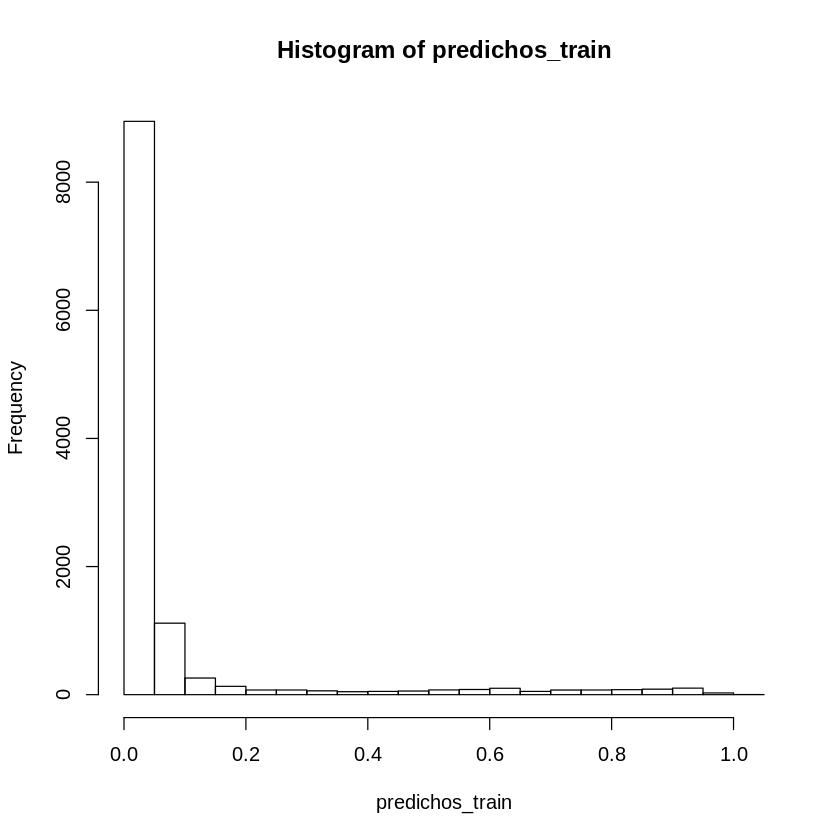

In [0]:
hist(predichos_train)

In [0]:
predichos_test <- h2o.predict(xgb, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)
head(predichos_test)

  |======================================================================| 100%


[1] 0.013084592 0.008556398 0.012025811 0.011684702 0.014163950 0.012554765

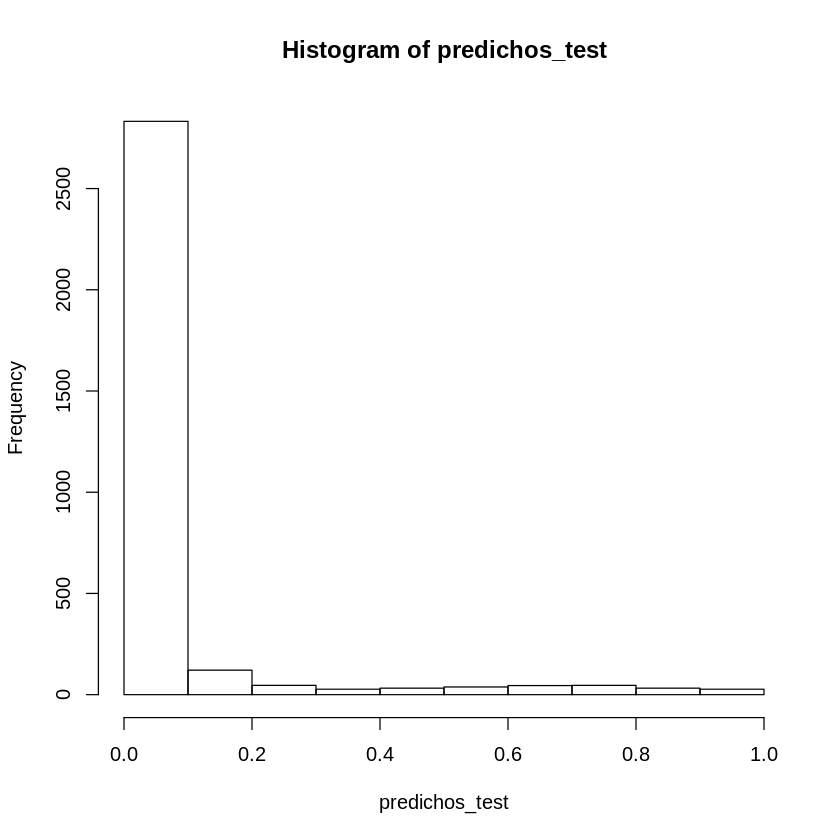

In [0]:
hist(predichos_test)

In [0]:
RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target_2015)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target_2015)))
)

data,RMSE
<fct>,<dbl>
Train,0.1003845
Test,0.1060405


# Predicciones 2019

In [0]:
predichos_2019 <- h2o.predict(xgb, as.h2o(df_test_2019)) %>%
  as.data.frame() %>% pull(predict)
head(predichos_2019)

  |======================================================================| 100%
  |======================================================================| 100%


[1] 0.01410912 0.01690232 0.01268599 0.01136317 0.01169489 0.01210092

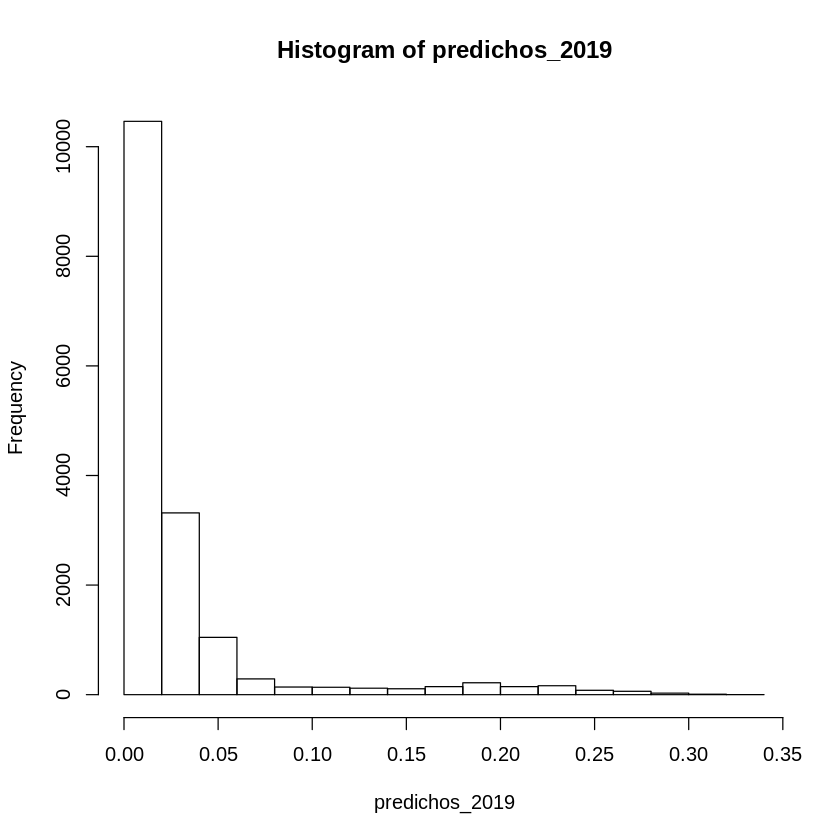

In [0]:
hist(predichos_2019)

In [0]:
df_test_2019 %>% 
  select(Square_ID) %>% 
  mutate(target_2019 = predichos_2019) ->
  predicciones42
head(predicciones42)

,Square_ID,target_2019
,<chr>,<dbl>
1,4e3c3896-14ce-11ea-bce5-f49634744a41,0.01410912
2,4e3c3897-14ce-11ea-bce5-f49634744a41,0.01690232
3,4e3c3898-14ce-11ea-bce5-f49634744a41,0.01268599
4,4e3c3899-14ce-11ea-bce5-f49634744a41,0.01136317
5,4e3c389a-14ce-11ea-bce5-f49634744a41,0.01169489
6,4e3c389b-14ce-11ea-bce5-f49634744a41,0.01210092


In [0]:
write.csv(predicciones42, file = "Submission42.csv", row.names = FALSE)

# Modelo XGB 2

In [4]:
# Cargando datos
load("/df_test19.Rdata")
load("/df_train15.Rdata")

# Cargando  e iniciando h2o
library(h2o)
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Cargando tidyverse
library(tidyverse)
  
# Train y Test h2o
df_train %>% 
  select(target_2015, elevation, rugos_near8, TRI_near8, LC_Type1,
         slope_near8, lat, long, TPI_near8, de_prec,
         ric_prec, PS7, PS9, PS12, PS17) %>% 
  mutate_each(funs(replace(., which(is.na(.)), mean(., na.rm=TRUE)))) ->
  df_train2

# Datos h2o
datos_h2o <- as.h2o(x = df_train2, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.7, 0.10),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_H2O")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_H2O")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_H2O")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)


xgb2 <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb_model_2"
                  ,stopping_rounds = 3
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,score_tree_interval = 1
                  ,learn_rate=0.01
                  ,ntrees=500
                  ,subsample = 0.75
                  ,colsample_bytree = 0.75
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 0.0
                  ,max_runtime_secs = 3600
                  ,nfolds = 10
                  ,seed = 123
                  )


----------------------------------------------------------------------

Your next step is to start H2O:
    > h2o.init()

For H2O package documentation, ask for help:
    > ??h2o

After starting H2O, you can use the Web UI at http://localhost:54321
For more information visit http://docs.h2o.ai

----------------------------------------------------------------------



Attaching package: ‘h2o’


The following objects are masked from ‘package:stats’:

    cor, sd, var


The following objects are masked from ‘package:base’:

    &&, %*%, %in%, ||, apply, as.factor, as.numeric, colnames,
    colnames<-, ifelse, is.character, is.factor, is.numeric, log,
    log10, log1p, log2, round, signif, trunc





H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /tmp/RtmpNtV2Tq/file79789588e6/h2o_UnknownUser_started_from_r.out
    /tmp/RtmpNtV2Tq/file795292f0d5/h2o_UnknownUser_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         2 seconds 831 milliseconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_root_njm915 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   10.00 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.3
✔ tibble  3.0.0     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”
Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”


  |======================================================================| 100%
  |======================================================================| 100%


  |======================================================================| 100%


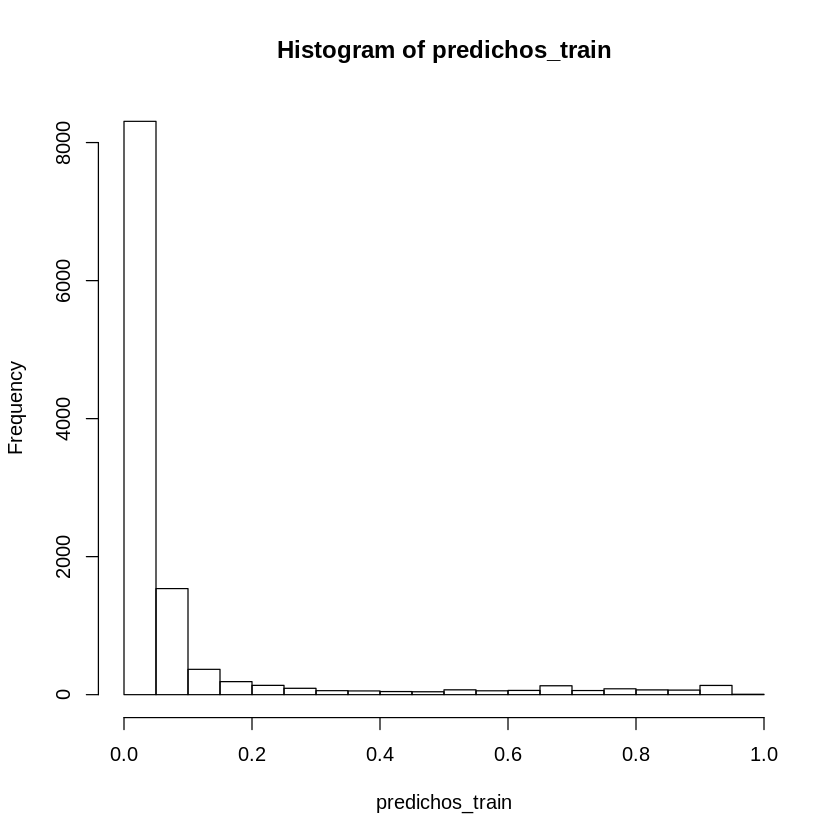

In [5]:
predichos_train <- h2o.predict(xgb2, datos_train_h2o) %>%
  as.data.frame() %>% pull(predict)
hist(predichos_train)

  |======================================================================| 100%


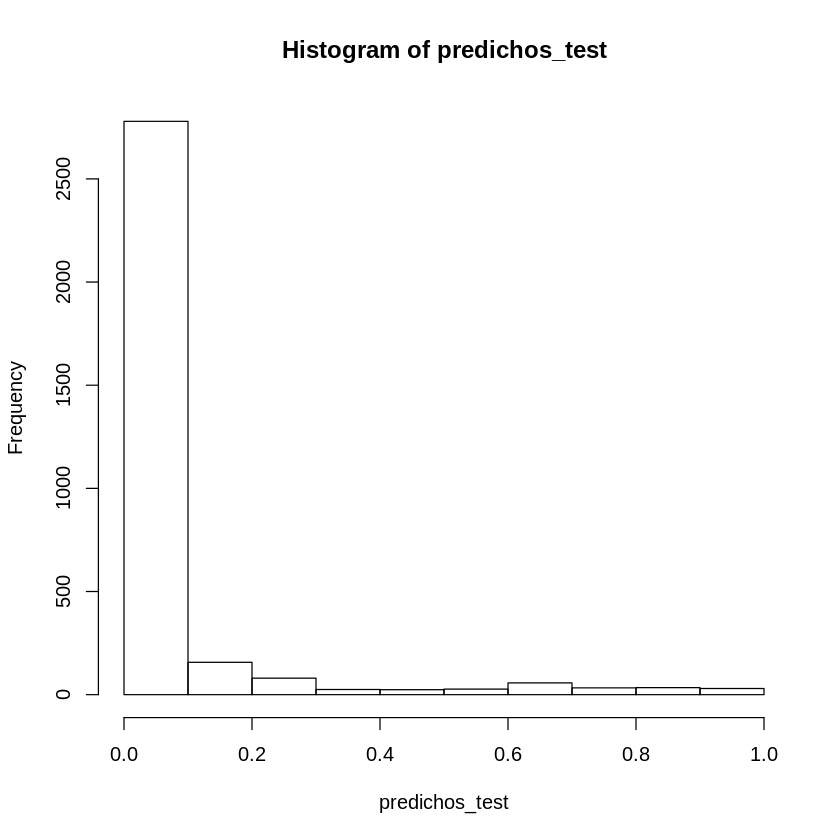

In [6]:
predichos_test <- h2o.predict(xgb2, datos_test_h2o) %>%
  as.data.frame() %>% pull(predict)
hist(predichos_test)

In [9]:
RMSE <- function(pred, obs, na.rm = FALSE){
  sqrt(mean((pred - obs)^2, na.rm = na.rm))
}

data.frame(
  data = c("Train", "Test"),
  RMSE = c(RMSE(pred = predichos_train, obs = as.vector(datos_train_h2o$target_2015)),
           RMSE(pred = predichos_test, obs = as.vector(datos_test_h2o$target_201)))
)

data,RMSE
<fct>,<dbl>
Train,0.1038722
Test,0.1103700


  |======================================================================| 100%
  |======================================================================| 100%


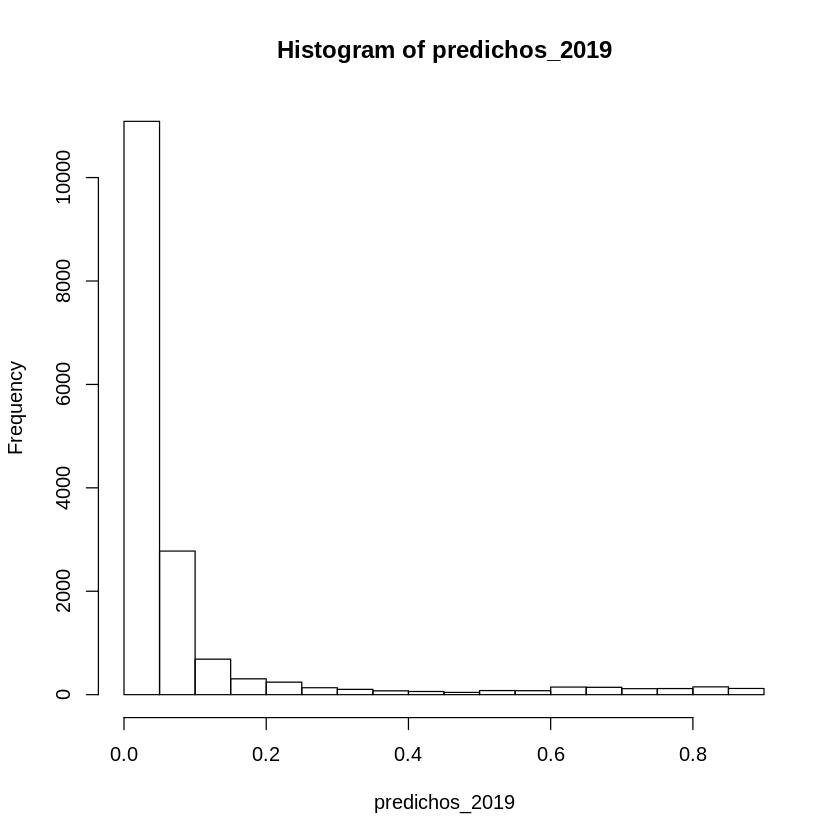

In [11]:
predichos_2019 <- h2o.predict(xgb2, as.h2o(df_test2)) %>%
  as.data.frame() %>% pull(predict)
hist(predichos_2019)

Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(Square_ID, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(flood_15, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(long_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(lat_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(elev_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(var_prec, na.rm = TRUE):
“argument is not numeric or logical: returning NA”


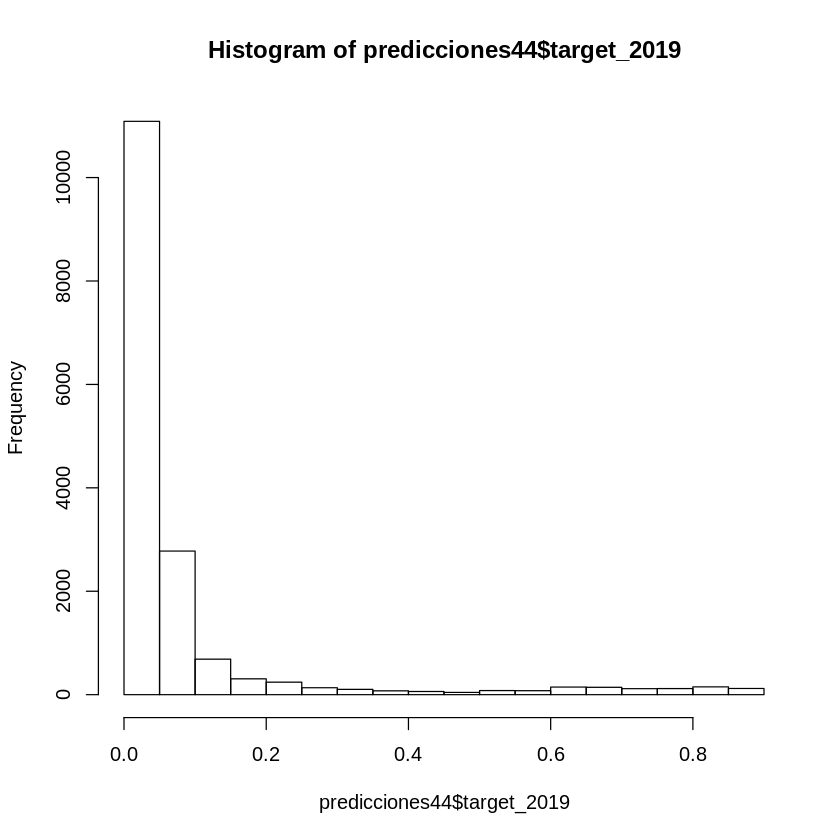

In [14]:
df_test %>% 
  mutate_each(funs(replace(., which(is.na(.)), mean(., na.rm=TRUE)))) ->
  df_test2
df_test2 %>% 
  select(Square_ID) %>% 
  mutate(target_2019 = predichos_2019) ->
  predicciones44
hist(predicciones44$target_2019) 

In [0]:
write.csv(predicciones44, file = "Submission44.csv", row.names = FALSE)

# XGB 3

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         34 minutes 29 seconds 
    H2O cluster timezone:       Etc/UTC 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.30.0.1 
    H2O cluster version age:    6 days  
    H2O cluster name:           H2O_started_from_R_root_njm915 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   9.92 GB 
    H2O cluster total cores:    2 
    H2O cluster allowed cores:  2 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4 
    R Version:                  R version 3.6.3 (2020-02-29) 



Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(long_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(lat_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(elev_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(var_prec, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(LC_Type1, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(Square_ID, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(flood_15, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message in mean.default(long_factor, na.rm = TRUE):
“argument is not numeric or logical: returning NA”
Warning message 

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


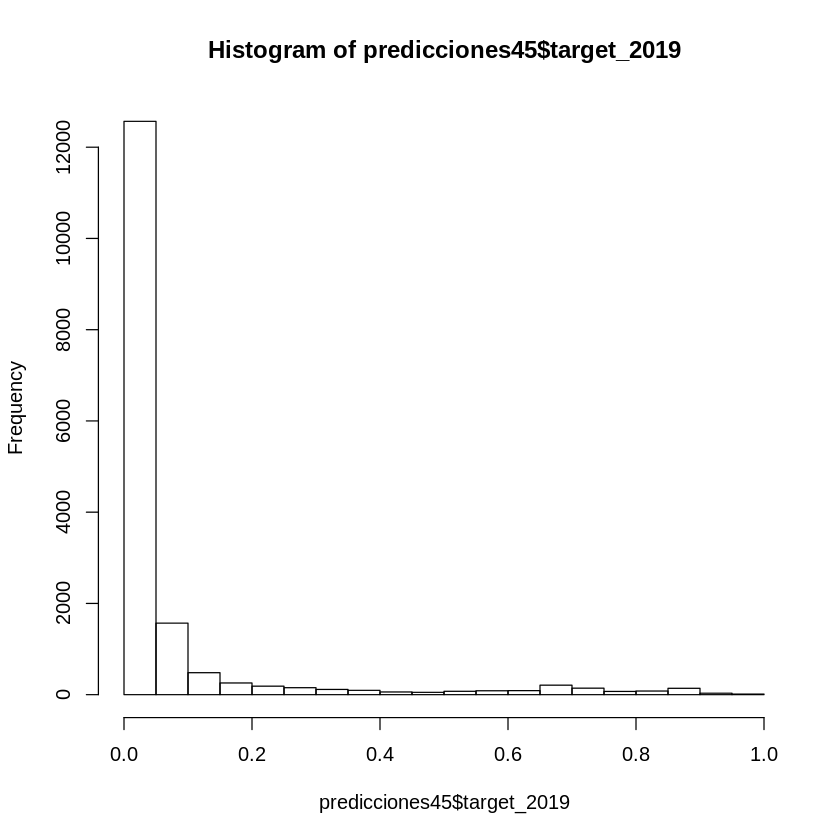

In [19]:
# Cargando datos
load("/df_test19.Rdata")
load("/df_train15.Rdata")

# Cargando  e iniciando h2o
library(h2o)
h2o.init(nthreads = -1, port = 54321, max_mem_size = "10g")

# Cargando tidyverse
library(tidyverse)
  
# Train y Test h2o
df_train %>% 
  select(-Square_ID, -flood_15) %>% 
  mutate_each(funs(replace(., which(is.na(.)), mean(., na.rm=TRUE)))) ->
  df_train2

 df_test %>% 
  mutate_each(funs(replace(., which(is.na(.)), mean(., na.rm=TRUE)))) ->
  df_test2 

# Datos h2o
datos_h2o <- as.h2o(x = df_train2, destination_frame = "datos_h2o")

particiones <- h2o.splitFrame(data = datos_h2o, ratios = c(0.6, 0.20),
                              seed = 123)
datos_train_h2o <- h2o.assign(data = particiones[[1]], key = "datos_train_H2O")
datos_val_h2o   <- h2o.assign(data = particiones[[2]], key = "datos_val_H2O")
datos_test_h2o  <- h2o.assign(data = particiones[[3]], key = "datos_test_H2O")

# Se define la variable respuesta y los predictores.
var_respuesta <- "target_2015"

# Para este modelo se emplean todos los predictores disponibles.
predictores   <- setdiff(h2o.colnames(datos_train_h2o), var_respuesta)


xgb3 <- h2o.xgboost(x = predictores
                  ,y = var_respuesta
                  ,training_frame = datos_train_h2o
                  ,validation_frame = datos_val_h2o
                  ,model_id = "xgb_model_3"
                  ,stopping_rounds = 3
                  ,stopping_metric = "RMSE"
                  ,distribution = "poisson"
                  ,score_tree_interval = 1
                  ,learn_rate=0.03
                  ,ntrees=1000
                  ,subsample = 0.8
                  ,colsample_bytree = 0.8
                  ,tree_method = "hist"
                  ,grow_policy = "lossguide"
                  ,booster = "gbtree"
                  ,gamma = 0.001,
                  ,max_depth = 5, #default =  6
                  ,nfolds = 10,
                  ,reg_lambda = 0.5
                  ,reg_alpha = 0.5
                  ,seed = 123
                  )

predichos_2019 <- h2o.predict(xgb3, as.h2o(df_test2)) %>%
  as.data.frame() %>% pull(predict)

df_test2 %>% 
  select(Square_ID) %>% 
  mutate(target_2019 = predichos_2019) ->
  predicciones45
hist(predicciones45$target_2019) 

In [0]:
write.csv(predicciones45, file = "Submission45.csv", row.names = FALSE)

# Grid XGB con todas las variables